In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torch.optim as optim
from datagen import *
from nets import *
from backdoor import Backdoor
from defense import Defense

In [6]:
backdoor = Backdoor(VggNet, config='11-layer', channels=3, classes=10)
backdoor.create_models(optim.SGD, nn.CrossEntropyLoss, lr=0.01)
backdoor.load_data(torchvision.datasets.CIFAR10, ImageEntity, pct=0.01)
classes = backdoor.get_classes()
torch.cuda.empty_cache()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
n = len(backdoor)
targets = {i: i + 1 if i < 9 else 0 for i in range(10)}
patches = ImagePatch((10, 10), 3, 'random').get_patches(n)
modifications = (None, [RotateTransform()], [LabelTransform(targets)])
merge = ImageMerge(select=True)
backdoor.poison(patches, modifications, merge, pct=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
backdoor.train(2, epochs=3, verbose=True, device=device)

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 9.78 GiB total capacity; 1.03 GiB already allocated; 255.94 MiB free; 1.04 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
backdoor.eval(verbose=True, device=device)

Accuracy on Clean | Base 69.79% | Trojan 70.43% | Difference 0.64%
Base Accuracy on Poison 3.94% | Attack Success Rate (ASR): 61.04%
Average Tensor Distance: 329.91 | Net Tensor Difference 16495698.69


(0.6979, 0.7043, 0.0394, 0.6104, 329.91397389404295, 16495698.694702148)

In [ ]:
defense = Defense(backdoor)
defense.detect(backdoor.base, device=device, threshold=0.1)

Patch size (5, 5) | Synthetic Poison Accuracy 68.40% | Original Accuracy 69.79% | Difference -1.39%
Patch size (6, 6) | Synthetic Poison Accuracy 68.12% | Original Accuracy 69.79% | Difference -1.67%
Patch size (7, 7) | Synthetic Poison Accuracy 67.18% | Original Accuracy 69.79% | Difference -2.61%
Patch size (8, 8) | Synthetic Poison Accuracy 66.44% | Original Accuracy 69.79% | Difference -3.35%
Patch size (9, 9) | Synthetic Poison Accuracy 65.73% | Original Accuracy 69.79% | Difference -4.06%
Patch size (10, 10) | Synthetic Poison Accuracy 65.88% | Original Accuracy 69.79% | Difference -3.91%
Average Accuracy 66.96% | Average Difference -2.83% | Lowest Score: 65.73% | Likihood of Backdoor: Low


([0.684, 0.6812, 0.6718, 0.6644, 0.6573, 0.6588],
 [-0.013899999999999912,
  -0.016699999999999937,
  -0.026100000000000012,
  -0.033499999999999974,
  -0.04059999999999997,
  -0.03909999999999991])

In [ ]:
defense.view_named_modules()

avgpool: AdaptiveAvgPool2d(output_size=(7, 7))
drop: Dropout(p=0.5, inplace=False)
fc1: Linear(in_features=25088, out_features=4096, bias=True)
fc2: Linear(in_features=4096, out_features=4096, bias=True)
fc3: Linear(in_features=4096, out_features=10, bias=True)
layers: Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=1, dilation=1, ceil_mode=False)
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

In [ ]:
defense.reset()

In [ ]:
defense.prune(['layers.16', 'layers.18', 'fc1'], amount=0.7)

In [ ]:
defense.retrain(epochs=3, verbose=True, device=device)

Training started
Epoch 1/3 | 24.95% | Loss: 1.6382 | Samples trained: 12480/50000
Epoch 1/3 | 49.90% | Loss: 1.6354 | Samples trained: 24960/50000
Epoch 1/3 | 74.86% | Loss: 1.6294 | Samples trained: 37440/50000
Epoch 1/3 | 99.81% | Loss: 1.6195 | Samples trained: 49920/50000
Epoch 1 complete | Loss: 1.6192
Epoch 2/3 | 24.95% | Loss: 1.6342 | Samples trained: 12480/50000
Epoch 2/3 | 49.90% | Loss: 1.6330 | Samples trained: 24960/50000
Epoch 2/3 | 74.86% | Loss: 1.6283 | Samples trained: 37440/50000
Epoch 2/3 | 99.81% | Loss: 1.6189 | Samples trained: 49920/50000
Epoch 2 complete | Loss: 1.6187
Epoch 3/3 | 24.95% | Loss: 1.6355 | Samples trained: 12480/50000
Epoch 3/3 | 49.90% | Loss: 1.6321 | Samples trained: 24960/50000
Epoch 3/3 | 74.86% | Loss: 1.6274 | Samples trained: 37440/50000
Epoch 3/3 | 99.81% | Loss: 1.6176 | Samples trained: 49920/50000
Epoch 3 complete | Loss: 1.6173
Training complete | Net Average Loss: 1.6184 | Total epochs: 3


1.6184098593943101

In [ ]:
defense.eval(device=device)

Accuracy on clean | Base 69.79% | Trojan 70.43% | Defense 62.10%
Accuracy on Posion | Base 3.94% | Defense 12.62% | Trojan ASR 61.04%
Difference from Baseline | Trojan 0.64% | Defense -7.69%
Defense Effectiveness | 48.42% decrease in ASR


(0.6979, 0.0394, 0.7043, 0.6104, 0.621, 0.1262)

In [ ]:
loader = defense.block()
dataiter = iter(loader)

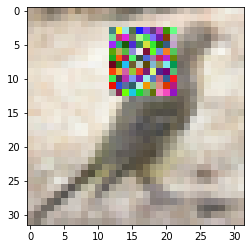

In [ ]:
inputs, labels = dataiter.next()
img = inputs[0].numpy().astype(np.uint8)
plt.imshow(img, cmap='gray')
plt.show()

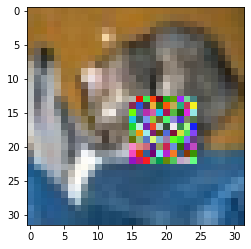

In [ ]:
patch = ImagePatch((9, 9), 3, 'random')
cleantrain, poisontrain, cleantest, poisontest = backdoor.get_datasets()
clean = cleantrain[0]
poison = poisontest[0]
# clean.show()
poison.show()
# patch.show()

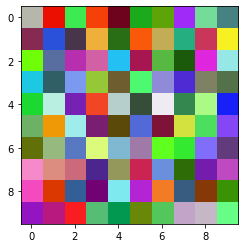

2375.033052401587 5399.665455555556
2374.5732248132504 5494.302528408609


In [ ]:
for i in range(poison.shape[0] - patch.shape[0]):
    for j in range(poison.shape[1] - patch.shape[1]):
        local = poison.get_data()[i:i + patch.shape[0], j:j + patch.shape[1], :]
        print(np.var(local))